# 2. Clustering

As the first step towards our recommender engine, we need to group the users into clusters. This notebook begins with a building our dataframe by merging all data together to all_orders. Then we proceed to feature generate aisles per share before doing a PCA to reduce the number of features (products that is) to increase performance before using kmeans to cluster into the optimal set op segments. 

In [1]:
import pandas as pd
import sys
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

## 2.1 Preparing the dataframe 

In [2]:
#loading all the data from the instacart zip 
products = pd.read_csv('../data/products.csv')
aisles = pd.read_csv('../data/aisles.csv')
departments = pd.read_csv('../data/departments.csv')
order_products_prior = pd.read_csv('../data/order_products__prior.csv')
order_products_train = pd.read_csv('../data/order_products__train.csv')
orders = pd.read_csv('../data/orders.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#creating one big dataframe called all_orders with most of the features included. 
all_orders = pd.concat([order_products_prior,order_products_train])
all_orders = all_orders.merge(orders[['order_id','user_id']], on='order_id', how='inner')
all_orders = all_orders.merge(products, on = 'product_id', how='inner')
all_orders = all_orders.merge(departments, on = 'department_id', how='inner')
all_orders = all_orders.merge(aisles, on = 'aisle_id', how='inner')


## 2.2 Feature Engineering "Aisle Share"

Before running our kmeans clustering algorithm, we wanted to develop a feature that would capture the relationship between the products purchased and aisles per user. We did this by counting the total number of products by aisle over total products purchased. 

In [4]:
#How many products the user bought by aisle over all their orders. 
cnt_per_aisle = all_orders[['user_id','aisle','product_name']].groupby(['user_id', 'aisle']).count().reset_index() 

cnt_per_aisle = cnt_per_aisle.rename(columns={'product_name':'product_cnt_per_aisle'})

In [5]:
cnt_per_aisle

,user_id,aisle,product_cnt_per_aisle
0,1,candy chocolate,2
1,1,cereal,4
2,1,cream,3
3,1,fresh fruits,5
4,1,milk,1
...,...,...,...
5919835,206209,soft drinks,11
5919836,206209,soy lactosefree,10
5919837,206209,spices seasonings,1
5919838,206209,trash bags liners,1


In [6]:
#Total product purchased by user id 
ttl_per_user = cnt_per_aisle.groupby(["user_id"]).sum()
ttl_per_user

,product_cnt_per_aisle
user_id,
1,70
2,226
3,88
4,18
5,46
...,...
206205,51
206206,285
206207,223


In [7]:
#calculating the aisle share by user id 
aisle_share_per_user = cnt_per_aisle.merge(ttl_per_user, how="left", on="user_id")
aisle_share_per_user["aisle_share"] = aisle_share_per_user["product_cnt_per_aisle_x"] / aisle_share_per_user["product_cnt_per_aisle_y"]
aisle_share_per_user.drop(["product_cnt_per_aisle_x", "product_cnt_per_aisle_y"], axis=1, inplace=True)
aisle_share_per_user

,user_id,aisle,aisle_share
0,1,candy chocolate,0.028571
1,1,cereal,0.057143
2,1,cream,0.042857
3,1,fresh fruits,0.071429
4,1,milk,0.014286
...,...,...,...
5919835,206209,soft drinks,0.080292
5919836,206209,soy lactosefree,0.072993
5919837,206209,spices seasonings,0.007299
5919838,206209,trash bags liners,0.007299


## 2.3 Preparing our dataset for dimensionality reduction

Before performing our principal component analysis we need to adjust our dataframe using pivot to transform our aisle per share into columns (features). 

In [8]:
#Setting aisles as columns by user id using pivot. 
aisle_share_pivot = aisle_share_per_user.pivot(index="user_id", columns="aisle", values="aisle_share")
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.014286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571
2,NaN,0.013274,NaN,NaN,NaN,NaN,0.008850,NaN,NaN,NaN,...,0.013274,0.004425,0.004425,NaN,NaN,NaN,NaN,0.008850,NaN,0.185841
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045455,0.011364,NaN,NaN,NaN,NaN,NaN,0.022727,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.055556,NaN,NaN,NaN,0.055556,NaN,NaN
5,0.021739,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,NaN,NaN,0.019608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176471
206206,NaN,0.014035,NaN,NaN,NaN,NaN,0.014035,0.003509,NaN,NaN,...,0.003509,NaN,NaN,NaN,NaN,0.003509,NaN,0.003509,NaN,NaN
206207,NaN,NaN,NaN,NaN,0.004484,NaN,NaN,NaN,NaN,NaN,...,0.013453,0.017937,NaN,0.008969,0.004484,NaN,NaN,0.049327,NaN,0.067265


## 2.4 Dimensionality reduction using PCA 
with 134 features (columns from our pivot) PCA can help us reduce the complexity and size by lowering the dimensionality without loosing out on too much explained variance. 

### 2.4.1 Finding the optimal number of dimensions

In [9]:
#transforming our using PCA and finding the optimal explained variance with a given threshold of 80%
pca = PCA()
pca.fit_transform(aisle_share_pivot.fillna(0))
cumsum = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.80 #tried differnet trsh
d = np.argmax(cumsum >= threshold) + 1

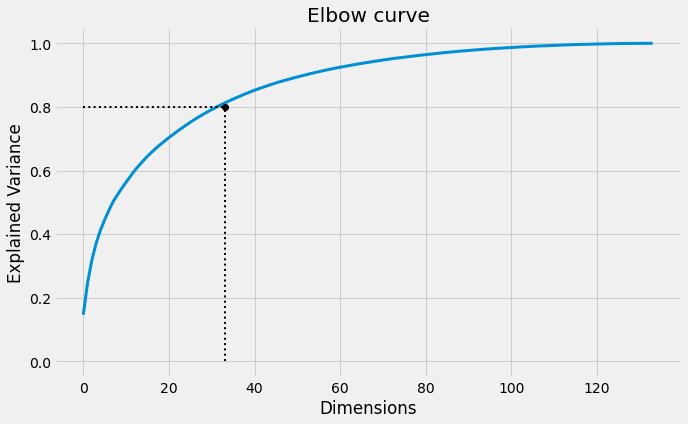

In [10]:
#graphically displaying the optimal components 
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))
plt.plot(cumsum, linewidth=3)
plt.title("Elbow curve")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:", linewidth=2)
plt.plot([0, d], [threshold, threshold], "k:",linewidth=2)
plt.plot(d, threshold, "ko")
plt.grid(True)
plt.show()

In [11]:
d

33

Using the elbow curve and a threshold of 80% explained variance, we find the optimal nubmer of dimensions to be 33. We will now create a seperate 

### 2.4.2 Reducing our dataframe using 33 components

In [12]:
#creating a dataframe with d number of components. 
pca = PCA(n_components=d)
prinicpalComponents = pca.fit_transform(aisle_share_pivot.fillna(0))

PCA_components = pd.DataFrame(prinicpalComponents)

In [13]:
PCA_components

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.122382,0.028613,-0.047848,0.012767,-0.075251,-0.111781,-0.100800,0.088254,-0.064046,-0.002316,...,-0.000239,0.087160,0.024957,0.090424,0.025758,-0.029691,0.016962,0.007656,0.007478,-0.036013
1,-0.034421,0.111616,-0.064131,-0.109468,0.073280,-0.029574,-0.049185,-0.058589,-0.010516,-0.018567,...,0.038667,0.008761,-0.003376,-0.005734,-0.000860,0.000566,0.010479,-0.022522,-0.017465,0.018343
2,0.063256,0.104112,0.000496,-0.014156,-0.047740,0.111114,-0.031847,0.013000,0.011876,0.004857,...,0.057544,-0.003629,0.000827,0.016770,-0.004331,-0.005091,-0.006652,0.005361,-0.015026,-0.016920
3,-0.094301,0.052756,0.001039,-0.005059,-0.071590,-0.017778,-0.025048,-0.038978,0.009955,-0.014063,...,0.008337,0.009847,0.001635,0.004966,-0.015293,0.013579,0.004320,-0.074719,0.056848,0.035981
4,0.089432,-0.031068,-0.022805,-0.011826,0.042319,0.111462,-0.015768,0.100989,0.025130,-0.036470,...,-0.005969,0.007861,0.002522,-0.006106,-0.000961,0.001346,-0.004581,0.007007,-0.008145,-0.001850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.001716,0.084855,-0.065398,-0.068637,0.114987,-0.028517,0.020657,0.023948,-0.027605,-0.016826,...,-0.003802,-0.023529,-0.007648,0.026005,-0.002041,-0.006026,0.019055,-0.018728,-0.006674,0.034482
206205,-0.089658,-0.046734,-0.048290,0.012790,-0.059583,-0.000548,-0.013954,-0.042917,0.143167,-0.059946,...,0.001058,0.044670,-0.011257,0.030284,0.030153,-0.032619,-0.004376,-0.013816,-0.001831,-0.011949
206206,-0.024827,-0.013520,-0.003968,-0.030920,0.032990,0.020681,0.037633,0.032873,-0.022790,-0.002534,...,0.007037,-0.004249,0.012868,-0.007791,0.006589,-0.005101,0.005513,-0.004529,-0.006947,-0.002832
206207,-0.009310,-0.003375,-0.045594,-0.012232,0.013766,0.055680,0.008124,0.029490,-0.010675,0.020760,...,-0.011505,-0.001448,-0.009168,0.012139,-0.002919,-0.003860,-0.006573,0.001843,-0.017673,-0.000191


In [14]:
#sns.pairplot(PCA_components[range(d)])

## 2.5 Segmenting our users using K-Means

### 2.5.1 Find optimal number of clusters using elbow method

Using 3 different methods we evaluate the optimal number of clusters to use for our segmentation. 

In [15]:
#finding optimal number of clusters. 
sse = {}
labels = {}
for k in range(2,20):
    print(k)
    kmeans = KMeans(n_clusters = k).fit(PCA_components[range(d)])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


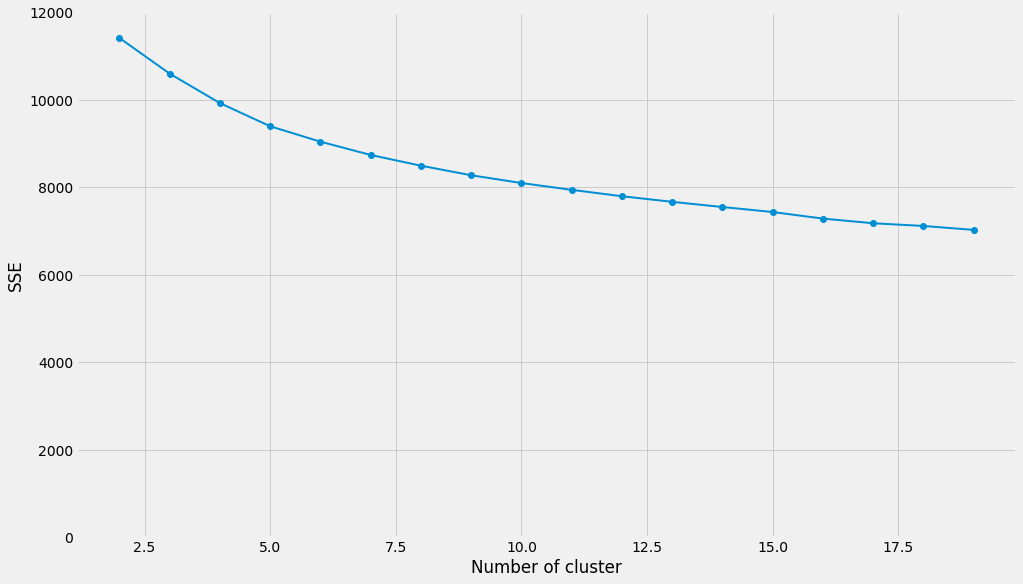

In [16]:
plt.figure(figsize=(15,9))
plt.plot(list(sse.keys()), list(sse.values()), "-o", linewidth=2)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.ylim(0, 12000)
plt.show()

Using the elbow method in this case is hard as there is no significant change in slope. 

Instead, we can find the place in which the slow down in pct %-change is the greatest.


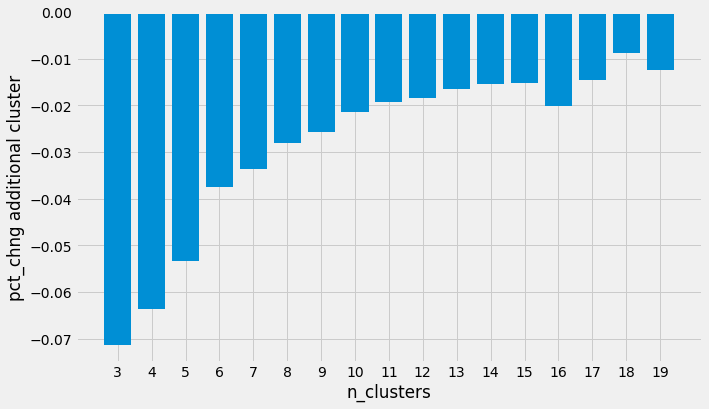

In [30]:
pct_change_clusters = pd.Series(sse.values()).pct_change()

plt.figure(figsize=(10,6))
plt.bar(sse.keys(), pct_change_clusters)
plt.xlabel("n_clusters")
plt.ylabel("pct_chng additional cluster")
plt.xticks(np.arange(3,20))
plt.show()

In [18]:
aisle_share_pivot = aisle_share_pivot.fillna(0)

In [19]:
k = 13

### 2.5.2 Alternative Clustering methods 

During our clustering we had a branch that explored DBSCAN/OPTICS as an alternative method for segmentation. However, due to the size of the dataset DBSCAN quickly ran out of memory as the algorithm in SciKit Learn is optimized towards performance. OPTICS however could solve this but the computational time never concluded. Therefore, K-Means was the optimal clustering algorithm for this size of data. 

## 2.6 Preparing our dataframe for collaborative filtering

We can now prepare our dataframe for export to use in our collaborative filtering in the next section. This is done over a few steps of merging dataframes with the goal of shaping a final df consisting of order_id, product_id, cluster & user_id.


In [20]:
#concatting cluster onto 
cluster_df = pd.concat([PCA_components[range(d)], pd.Series(labels[k]).rename('cluster')], axis = 1)

cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)

In [21]:
cluster_df

,user_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,cluster
0,1,-0.122382,0.028613,-0.047848,0.012767,-0.075251,-0.111781,-0.100800,0.088254,-0.064046,...,0.087160,0.024957,0.090424,0.025758,-0.029691,0.016962,0.007656,0.007478,-0.036013,11
1,2,-0.034421,0.111616,-0.064131,-0.109468,0.073280,-0.029574,-0.049185,-0.058589,-0.010516,...,0.008761,-0.003376,-0.005734,-0.000860,0.000566,0.010479,-0.022522,-0.017465,0.018343,10
2,3,0.063256,0.104112,0.000496,-0.014156,-0.047740,0.111114,-0.031847,0.013000,0.011876,...,-0.003629,0.000827,0.016770,-0.004331,-0.005091,-0.006652,0.005361,-0.015026,-0.016920,4
3,4,-0.094301,0.052756,0.001039,-0.005059,-0.071590,-0.017778,-0.025048,-0.038978,0.009955,...,0.009847,0.001635,0.004966,-0.015293,0.013579,0.004320,-0.074719,0.056848,0.035981,1
4,5,0.089432,-0.031068,-0.022805,-0.011826,0.042319,0.111462,-0.015768,0.100989,0.025130,...,0.007861,0.002522,-0.006106,-0.000961,0.001346,-0.004581,0.007007,-0.008145,-0.001850,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0.001716,0.084855,-0.065398,-0.068637,0.114987,-0.028517,0.020657,0.023948,-0.027605,...,-0.023529,-0.007648,0.026005,-0.002041,-0.006026,0.019055,-0.018728,-0.006674,0.034482,10
206205,206206,-0.089658,-0.046734,-0.048290,0.012790,-0.059583,-0.000548,-0.013954,-0.042917,0.143167,...,0.044670,-0.011257,0.030284,0.030153,-0.032619,-0.004376,-0.013816,-0.001831,-0.011949,9
206206,206207,-0.024827,-0.013520,-0.003968,-0.030920,0.032990,0.020681,0.037633,0.032873,-0.022790,...,-0.004249,0.012868,-0.007791,0.006589,-0.005101,0.005513,-0.004529,-0.006947,-0.002832,6
206207,206208,-0.009310,-0.003375,-0.045594,-0.012232,0.013766,0.055680,0.008124,0.029490,-0.010675,...,-0.001448,-0.009168,0.012139,-0.002919,-0.003860,-0.006573,0.001843,-0.017673,-0.000191,4


In [22]:
#Adding cluster number to our asile share per user dataframe 
cluster_aisle_br = aisle_share_per_user.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [23]:
cluster_aisle_br

,user_id,aisle,aisle_share,cluster
0,1,candy chocolate,0.028571,11
1,1,cereal,0.057143,11
2,1,cream,0.042857,11
3,1,fresh fruits,0.071429,11
4,1,milk,0.014286,11
...,...,...,...,...
5919835,206209,soft drinks,0.080292,1
5919836,206209,soy lactosefree,0.072993,1
5919837,206209,spices seasonings,0.007299,1
5919838,206209,trash bags liners,0.007299,1


In [24]:
all_orders_cluster = all_orders.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [25]:
all_orders_cluster

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle,cluster
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
1,104690,33120,2,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
2,132412,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
3,2808715,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
4,2894949,33120,5,0,202279,Organic Egg Whites,86,16,dairy eggs,eggs,6
...,...,...,...,...,...,...,...,...,...,...,...
33819101,2942910,36885,1,1,95228,Rose,134,5,alcohol,specialty wines champagnes,1
33819102,77392,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,1
33819103,679020,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,1
33819104,1264096,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,1


In [26]:
dummy_df = all_orders_cluster[["order_id", "product_id", "cluster", "user_id"]]

## 2.7 Exporting our clustered dataframe to pyarrow (for compression) for use in collaborative filtering algorithm.

In [27]:
import pyarrow as pa
import pyarrow.parquet as pq

table = pa.Table.from_pandas(dummy_df, preserve_index=False)

pq.write_table(table, f"dummy_k{k}.parquet")

ModuleNotFoundError: No module named 'pyarrow'

## Link to [3. item2vec](recommender_system/item2vec.ipynb) 